In [2]:
import os
import gc
import math
from google.colab import drive
from google.colab import files

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# image processing
from skimage import morphology, exposure, filters
from skimage.io import imread
from skimage.filters import frangi, threshold_otsu

# machine learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold


#Filters

In [5]:
class Filters:
  def __init__(self, dataset):
    self.dataset = dataset

  def frang(self, image, sigmas, alpha=1, beta=1, gamma=0.3):
    return frangi(image, sigmas=sigmas, alpha=alpha, beta=beta, gamma=gamma, black_ridges=True)

  def rmv_small_obj(self, image, min_size=5000, threshold=0.3):
    thresh_mask = image > threshold
    obj_mask = morphology.remove_small_objects(thresh_mask, min_size=min_size)
    filt_img = image * obj_mask
    return filt_img, thresh_mask, obj_mask

  def apply_filters(self, image, sigmas=np.arange(1.8, 4.1, 0.1)):
    filtered = []
    filtered_frang = self.frang(image, sigmas)
    filtered_frang_obj, thresh_mask, obj_mask = self.rmv_small_obj(filtered_frang)
    filtered.append(filtered_frang_obj)
    return filtered, thresh_mask, obj_mask


#DCA1

In [7]:
class DCA1(Dataset):
  def __init__(self, datadir, augment=False):
    self.datadir = datadir   # str
    self.augment = augment   # bool
    # original and ground truth images as lists of strings
    self.X = [f for f in os.listdir(datadir) if '_gt' not in f]
    self.Y = [g for g in os.listdir(datadir) if '_gt' in g]
    # instance of Filters
    self.filters = Filters(self)

  def __len__(self):
    if self.augment:
      return len(self.X) * 2
    return len(self.X)

  def __getitem__(self, index, visualize_masks=False):
    # augment dataset with vertically flipped images
    if self.augment and index >= len(self.X):
      ii = index - len(self.X)
      x_path = os.path.join(self.datadir, self.X[ii])
      y_path = os.path.join(self.datadir, self.Y[ii])
      # read image files as numpy arrays and flip rows
      x = imread(x_path)[::-1, :]
      y = imread(y_path)[::-1, :]
    else:
      x_path = os.path.join(self.datadir, self.X[index])
      y_path = os.path.join(self.datadir, self.Y[index])
      x = imread(x_path)
      y = imread(y_path)

    # apply filters
    filtered, thresh_mask, obj_mask = self.filters.apply_filters(x)

    if visualize_masks:
      fig, axs = plt.subplots(1, 4, figsize=(8, 2))
      axs[0].imshow(x, cmap='gray')
      axs[0].set_title('Original')
      axs[0].axis('off')
      filt_frang = self.filters.frang(x, sigmas=np.arange(1.8, 4.1, 0.1))
      axs[1].imshow(filt_frang, cmap='gray')
      axs[1].set_title('Frangi-filtered')
      axs[1].axis('off')
      axs[2].imshow(thresh_mask, cmap='gray')
      axs[2].set_title('Threshold mask')
      axs[2].axis('off')
      axs[3].imshow(obj_mask, cmap='gray')
      axs[3].set_title('Object mask')
      axs[3].axis('off')
      plt.tight_layout()
      plt.show()

    # 3D one-hot encoded ground truths
    y_onehot = np.zeros((y.shape[0], y.shape[1], 2), dtype=np.float32)
    y_onehot[..., 0] = (y == 0)    # background
    y_onehot[..., 1] = (y == 255)  # foreground

    # reshape into 1D tensor before feeding to MLP
    stacked = np.stack(filtered, axis=-1)
    return torch.tensor(stacked.copy(), dtype=torch.float32), torch.tensor(y_onehot.copy(), dtype=torch.float32)


##Instance of DCA1

In [8]:
drive.mount('/content/drive')
dca1_dir = '/content/drive/My Drive/db'
dca1 = DCA1(datadir=dca1_dir, augment=True)


Mounted at /content/drive


#Visualize Input/Output

IMAGE i=127


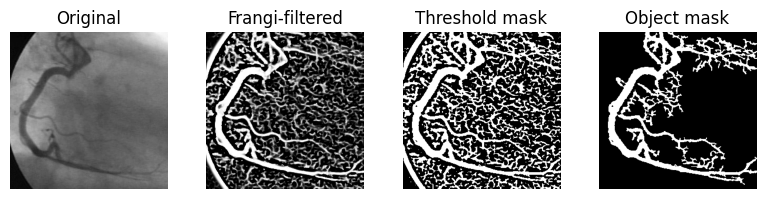

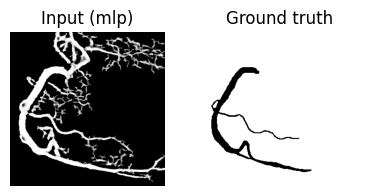

IMAGE i=22


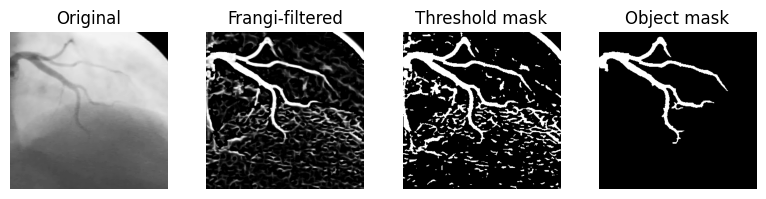

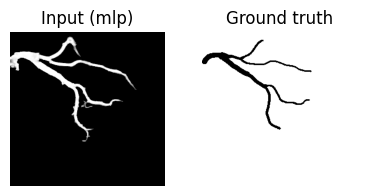

In [10]:
indices = [127, 22]

for i in indices:
  print(f"IMAGE i={i}")
  raw = dca1.__getitem__(i, visualize_masks=True)[0].numpy()[..., 0]
  ground = dca1.__getitem__(i, visualize_masks=False)[1].numpy()[..., 0]
  plt.figure(figsize=(4, 2))
  plt.subplot(1, 2, 1)
  plt.imshow(raw, cmap='gray')
  plt.axis('off')
  plt.title('Input (mlp)')
  plt.subplot(1, 2, 2)
  plt.imshow(ground, cmap='gray')
  plt.axis('off')
  plt.title('Ground truth')
  plt.tight_layout()
  plt.show()


### Intensity Distribution before/after Filtering

IMAGE i=127


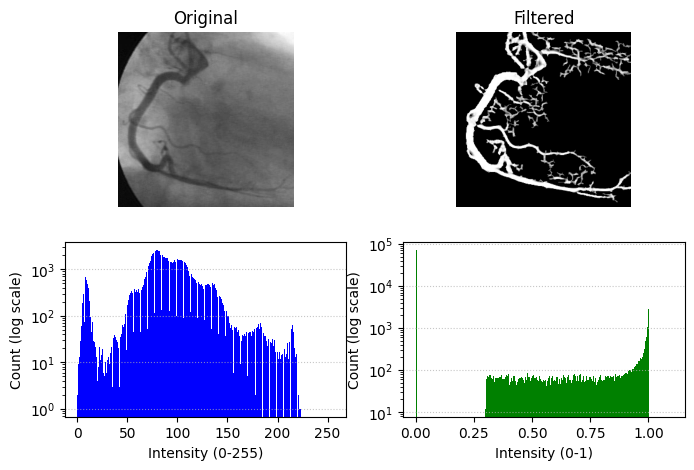

IMAGE i=22


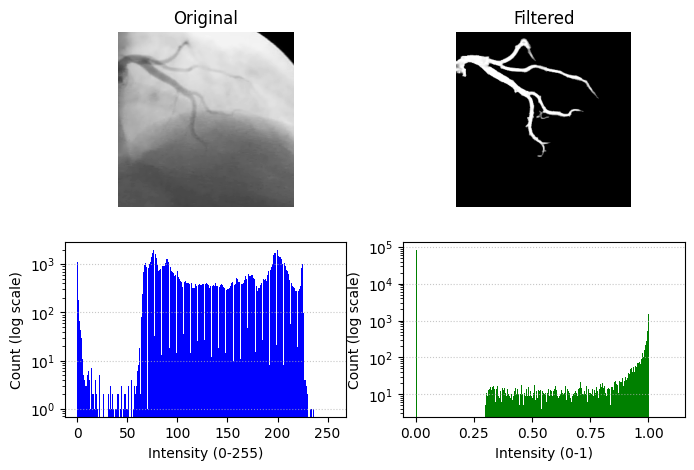

In [23]:
indices = [127, 22]

for i in indices:
  print(f"IMAGE i={i}")
  raw = imread(os.path.join(dca1.datadir, dca1.X[i]))   # can't use dca1.__getitem__ to get original images
  filtered = dca1[i][0].numpy()[..., 0]

  plt.figure(figsize=(8, 5))
  plt.subplot(2, 2, 1)
  plt.imshow(raw, cmap='gray')
  plt.axis('off')
  plt.title('Original')
  plt.subplot(2, 2, 2)
  plt.imshow(filtered, cmap='gray')
  plt.axis('off')
  plt.title('Filtered')
  plt.subplot(2, 2, 3)
  plt.hist(raw.flatten(), bins=256, range=(0, 256), color='blue')
  plt.yscale('log')
  plt.xlabel('Intensity (0-255)')
  plt.ylabel('Count (log scale)')
  plt.grid(axis='y', linestyle=':', alpha=0.7)
  plt.subplot(2, 2, 4)
  plt.hist(filtered.flatten(), bins=256, range=(0, 1.1), color='green')
  plt.yscale('log')
  plt.xlabel('Intensity (0-1)')
  plt.ylabel('Count (log scale)')
  plt.grid(axis='y', linestyle=':', alpha=0.7)
  plt.show()


#MLP

In [27]:
class MLP(nn.Module):             # inherits superclass nn.Module
  def __init__(self):             # constructor of superclass provides auto diff gradient, model saving, etc.
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(1, 9)    # 1 input neuron
    self.fc2 = nn.Linear(9, 9)    # 9 neurons per hidden layer
    self.out = nn.Linear(9, 2)    # 2 output neurons background/foreground
    self.relu = nn.ReLU()         # relu activation in all layers

  def forward(self, x):
    x=self.relu(self.fc1(x))     # 1st hidden layer
    x=self.relu(self.fc2(x))     # 2nd hidden layer
    logit=self.out(x)            # output layer
    return logit                 # raw logits

  # backpropagation: see training loop


#Training (13min/epoch)


----------Fold 1: Epoch 1/10---------------------------
Avg Train Loss = 1.84965694
Avg Validation Loss = 1.8064

----------Fold 1: Epoch 2/10---------------------------
Avg Train Loss = 1.77274920
Avg Validation Loss = 1.7332

----------Fold 1: Epoch 3/10---------------------------
Avg Train Loss = 1.70194599
Avg Validation Loss = 1.6653

----------Fold 1: Epoch 4/10---------------------------
Avg Train Loss = 1.63676063
Avg Validation Loss = 1.6052

----------Fold 1: Epoch 5/10---------------------------
Avg Train Loss = 1.57915737
Avg Validation Loss = 1.5505

----------Fold 1: Epoch 6/10---------------------------
Avg Train Loss = 1.52618371
Avg Validation Loss = 1.4985

----------Fold 1: Epoch 7/10---------------------------
Avg Train Loss = 1.47505004
Avg Validation Loss = 1.4495

----------Fold 1: Epoch 8/10---------------------------
Avg Train Loss = 1.42817918
Avg Validation Loss = 1.4074

----------Fold 1: Epoch 9/10---------------------------
Avg Train Loss = 1.38788882
Avg

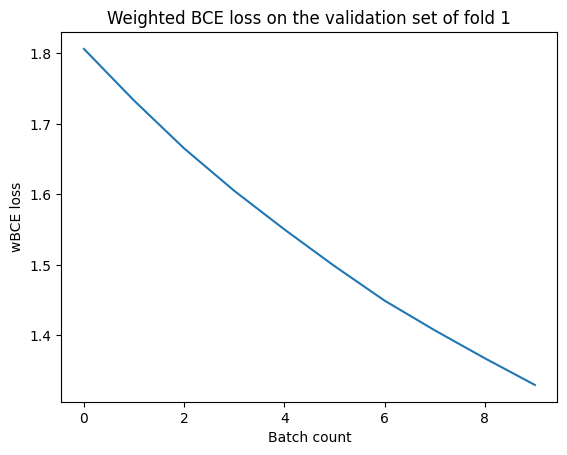

MLP model fold 1 saved as mlp_fold1.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fold 1/5 done.

----------Fold 2: Epoch 1/10---------------------------


KeyboardInterrupt: 

In [42]:
# use GPU for speedup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)

# weighted binary cross entropy loss function
def weighted_bce(logit, ground, weight_bgd=0.2, weight_fgd=0.8):
  pos_weight = torch.tensor(weight_fgd / weight_bgd).to(logit.device)   # both pos_weight and logit tensors must be on same device
  lossfct = nn.BCEWithLogitsLoss(pos_weight=pos_weight)                 # no sigmoid activation needed
  return lossfct(logit, ground)

def train_epoch(model, train_loader, step, lossfct):
  model.train()
  epoch_train_loss = 0.0
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    step.zero_grad()     # zeroe the gradient every epoch
    outputs = model(inputs)
    loss = lossfct(outputs, targets)
    loss.backward()      # gradient of wBCE loss function w.r.t weights and biases
    step.step()          # update MLP params in direction that reduces wBCE loss
    epoch_train_loss += loss.item()
  return epoch_train_loss / len(train_loader)   # average loss per epoch

def val_epoch(model, val_loader, lossfct):
  model.eval()
  epoch_valoss = 0.0
  with torch.no_grad():
    for inputs, targets in val_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      epoch_valoss += lossfct(outputs, targets).item()
  return epoch_valoss / len(val_loader)

def train_loop(train_indices, val_indices, fold):
  trainset = Subset(dca1, train_indices)
  valset = Subset(dca1, val_indices)
  train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
  val_loader = DataLoader(valset, batch_size=32, shuffle=False)

  model = MLP().to(device)
  step = optim.Adam(model.parameters(), lr=0.001)
  lossfct = weighted_bce

  train_losses, val_losses = [], []

  nepochs = 10
  for epoch in range(nepochs):
    print(f"\n----------Fold {fold}: Epoch {epoch + 1}---------------------------")
    avg_train_loss = train_epoch(model, train_loader, step, lossfct)
    print(f"Avg train loss = {avg_train_loss:.8f}")
    avg_val_loss = val_epoch(model, val_loader, lossfct)
    print(f"Avg validation loss = {avg_val_loss:.4f}")
    val_losses.append(avg_val_loss)

  return model, val_losses

def loss_plot(val_losses, fold):
  plt.figure()
  plt.plot(val_losses)
  plt.xlabel('Batch count')
  plt.ylabel('wBCE loss')
  plt.title(f'Weighted BCE loss on the validation set of fold {fold}')
  plt.show()

def save(model, fold):
  model_path = f'mlp_fold{fold}.pth'
  torch.save(model.state_dict(), model_path)
  print(f"MLP model fold {fold} saved as {model_path}")
  files.download(model_path)

# cross-validation
for fold, (train_indices, val_indices) in enumerate(kf.split(dca1), 1):
  model, val_losses = train_loop(train_indices, val_indices, fold)
  loss_plot(val_losses, fold)
  save(model, fold)
  print(f"Fold {fold}/5 done.")


#Load a pre-trained model

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load(fold_number, dataset, batch_size=1, n_splits=5):
  model_path = f'mlp_fold{fold_number}.pth'
  model = MLP().to(device)
  model.load_state_dict(torch.load(model_path, map_location=device))
  model.eval()
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
  for current_fold, (_, val_indices) in enumerate(kf.split(dataset), start=1):
    if current_fold == fold_number:
      val_loader = DataLoader(Subset(dataset, val_indices), batch_size=batch_size, shuffle=False)
      break
  return model, val_loader

foldn = 1
model, val_loader = load(foldn, dca1, batch_size=1)


<ipython-input-28-70f69bd72fe9>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


#Foreground probabilities

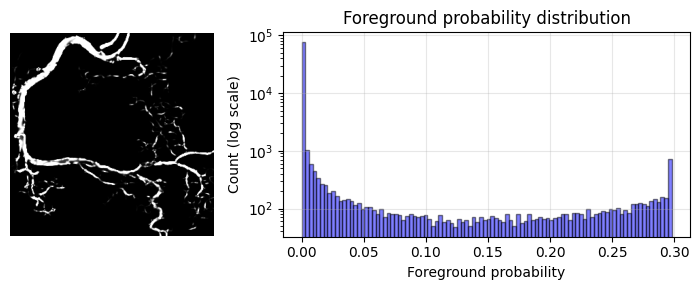

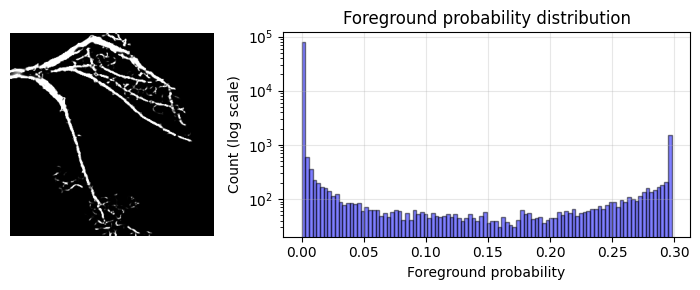

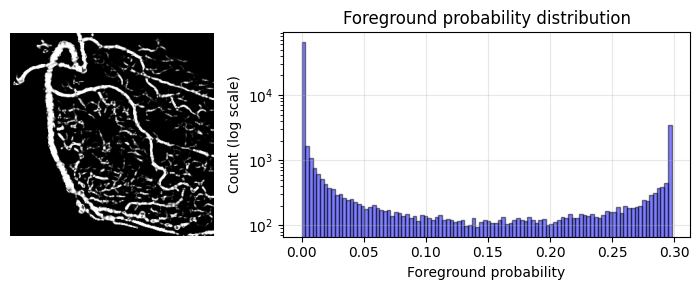

In [29]:
def fgd_histo(model, valoader, indices):
  model.eval()
  ii = 0
  c = 0

  for x, y in valoader:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x = x.to(device)
    nfilters = 1
    x_flat = x.view(-1, nfilters)

    with torch.no_grad():
      # convert logits to softmax probs
      preds = torch.softmax(model(x_flat), dim=1)
    preds = preds.view(x.size(0), 300, 300, 2)
    # foreground pixels have class label 1
    fgdprobs = preds[..., 1].cpu().numpy()

    for i in range(x.size(0)):
      if ii in indices:
        # contrast-stretch fgd probs to 5-95 percentile for visualization purposes
        fgdprobs_stretched = np.clip(
          (fgdprobs[i] - np.percentile(fgdprobs[i], 5)) /
          (np.percentile(fgdprobs[i], 95) - np.percentile(fgdprobs[i], 5)), 0, 1)

        plt.figure(figsize=(8, 3))
        gs = GridSpec(1, 3, width_ratios=[1, 2, 0.1])     # source: https://stackoverflow.com/questions/66880744/changing-the-gridspec-properties-after-generating-the-subplots
        ax1 = plt.subplot(gs[0])
        ax1.imshow(fgdprobs_stretched, cmap='gray', vmin=0, vmax=1)
        ax1.axis('off')
        ax2 = plt.subplot(gs[1])
        ax2.hist(fgdprobs[i].flatten(), bins=100, color='blue', alpha=0.5, edgecolor='black')
        ax2.set_yscale('log')
        ax2.set_xlabel('Foreground probability')
        ax2.set_ylabel('Count (log scale)')
        ax2.grid(alpha=0.3)
        ax2.set_title('Foreground probability distribution')
        plt.tight_layout()
        plt.show()

        c += 1
        if c == len(indices):
          return

      # if ii not in indices to plot, continue
      ii += 1

val_indices = np.arange(0, 3, 1)
fgd_histo(model, val_loader, val_indices)


#Segmentation: Otsu's method

otsu threshold = 0.1158


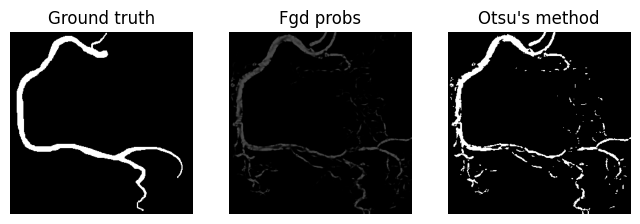

otsu threshold = 0.1262


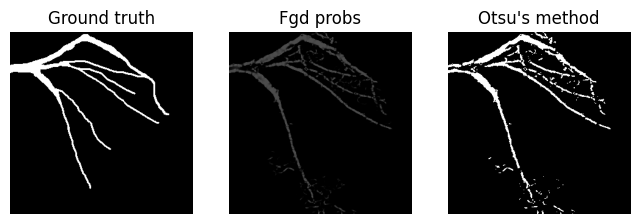

otsu threshold = 0.1262


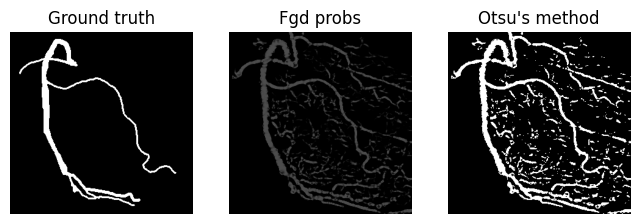

otsu threshold = 0.1262


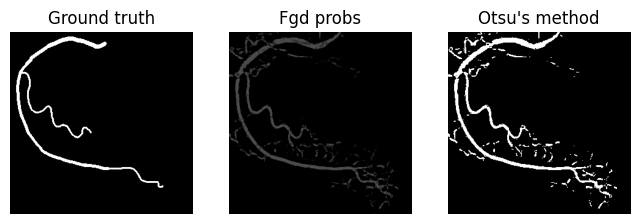

otsu threshold = 0.1204


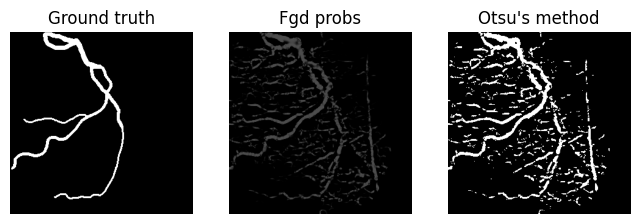

otsu threshold = 0.1251


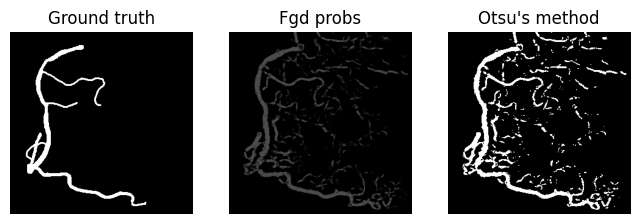

otsu threshold = 0.1332


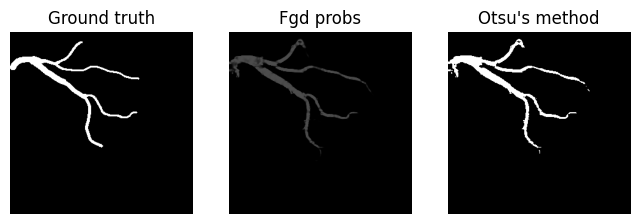

otsu threshold = 0.1216


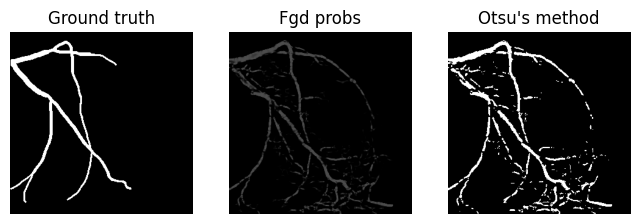

otsu threshold = 0.1146


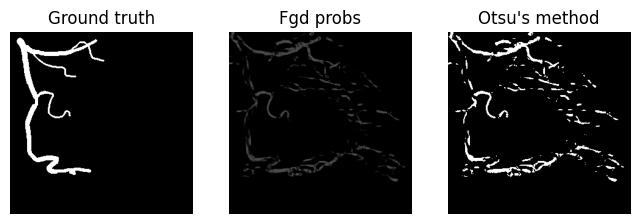

otsu threshold = 0.1286


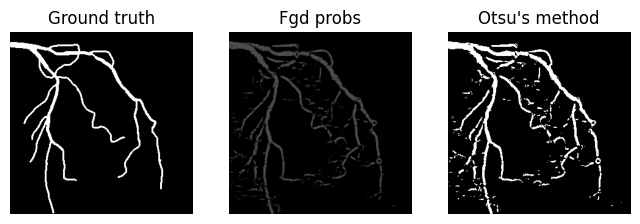

otsu threshold = 0.1239


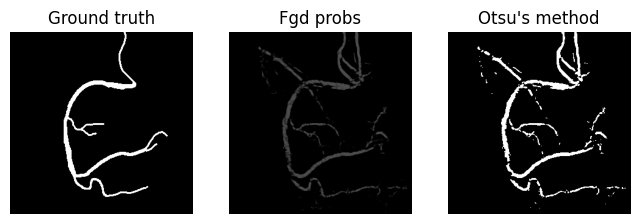

otsu threshold = 0.1332


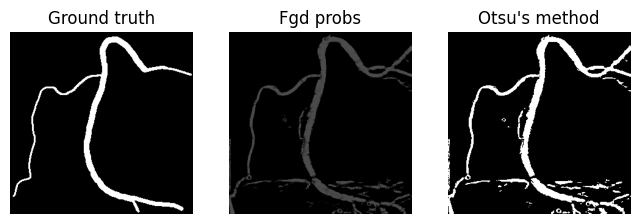

otsu threshold = 0.1251


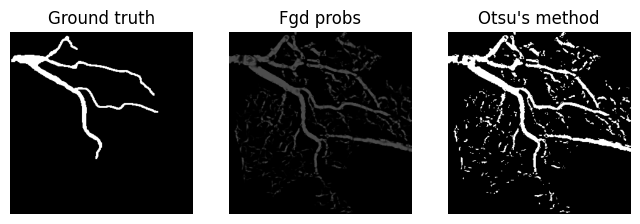

otsu threshold = 0.1297


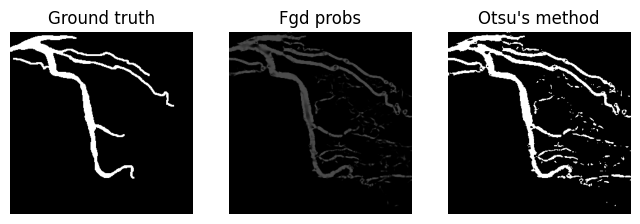

otsu threshold = 0.1286


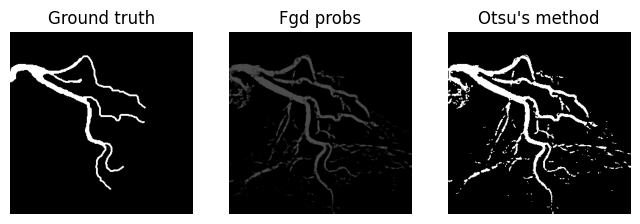

otsu threshold = 0.1297


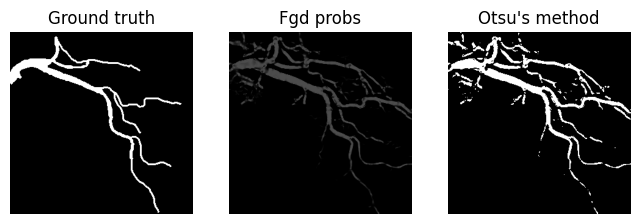

otsu threshold = 0.1286


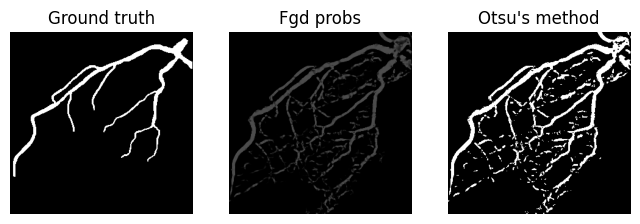

otsu threshold = 0.1251


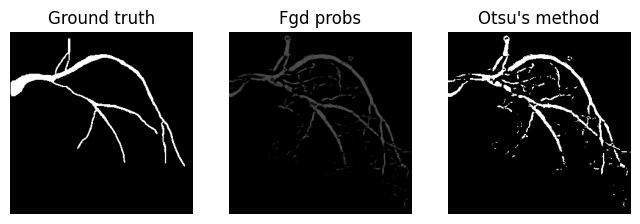

otsu threshold = 0.1309


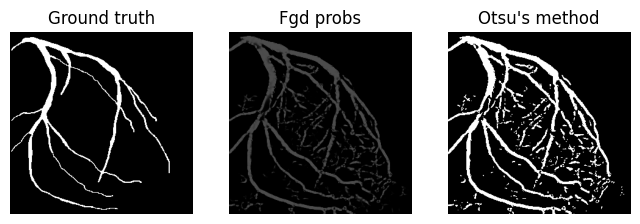

otsu threshold = 0.1274


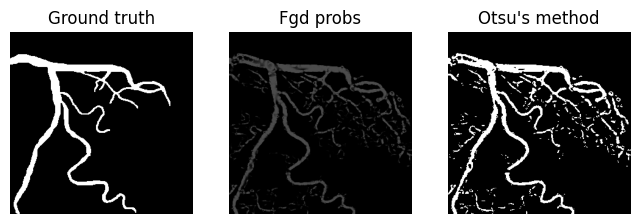

otsu threshold = 0.1251


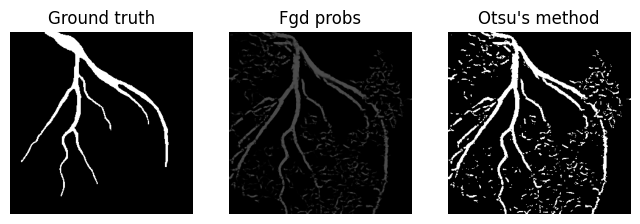

otsu threshold = 0.1297


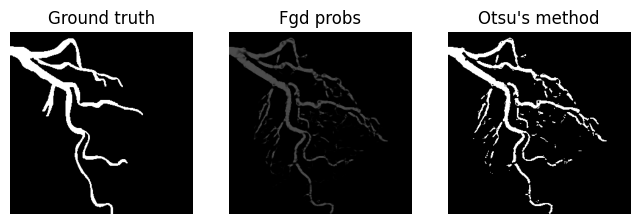

otsu threshold = 0.1169


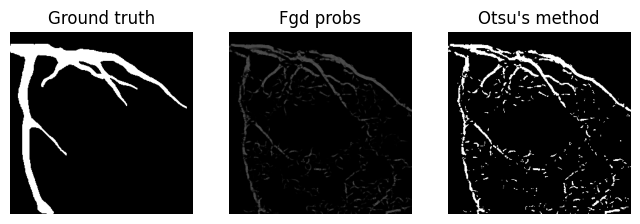

otsu threshold = 0.1262


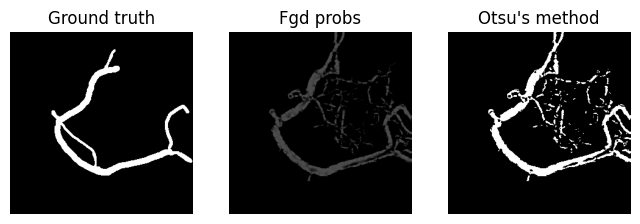

otsu threshold = 0.1181


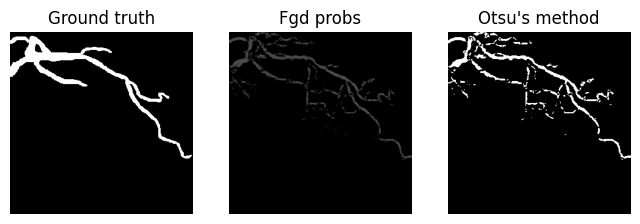

otsu threshold = 0.1251


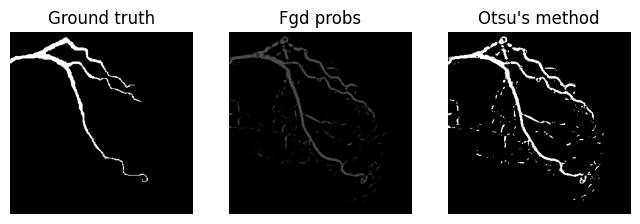

otsu threshold = 0.1239


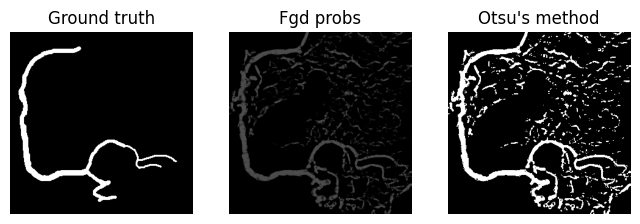

otsu threshold = 0.1204


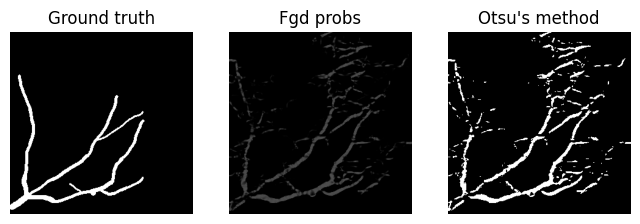

otsu threshold = 0.1320


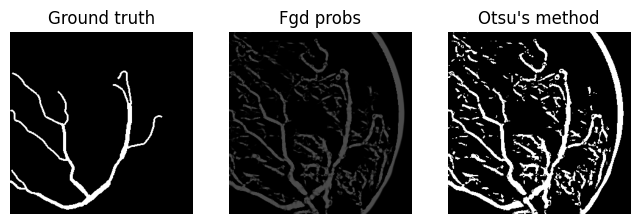

otsu threshold = 0.1158


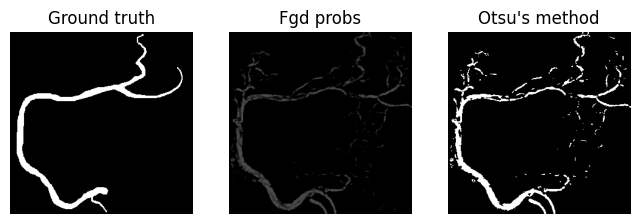

otsu threshold = 0.1251


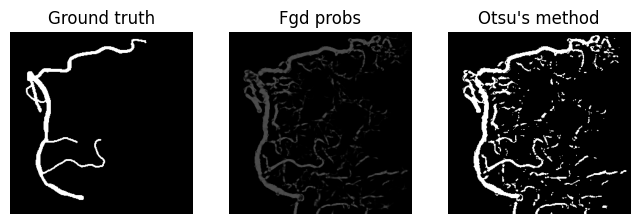

otsu threshold = 0.1274


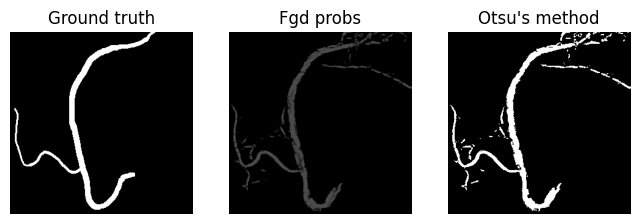

otsu threshold = 0.1332


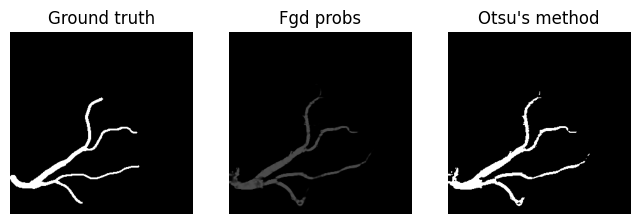

otsu threshold = 0.1146


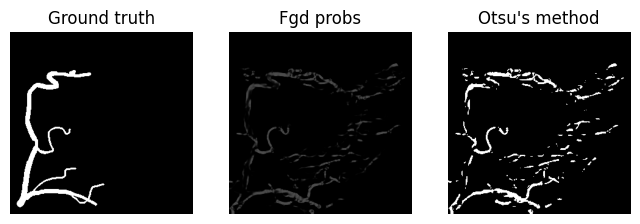

otsu threshold = 0.1320


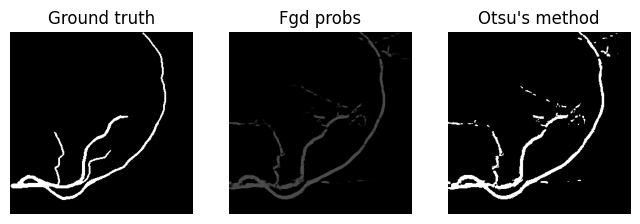

otsu threshold = 0.1286


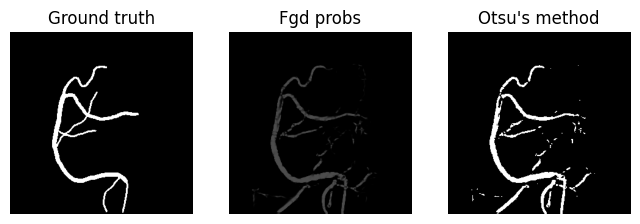

otsu threshold = 0.1286


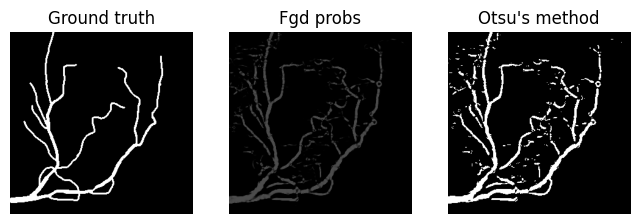

otsu threshold = 0.1274


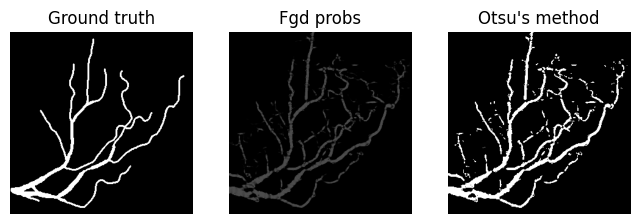

otsu threshold = 0.1239


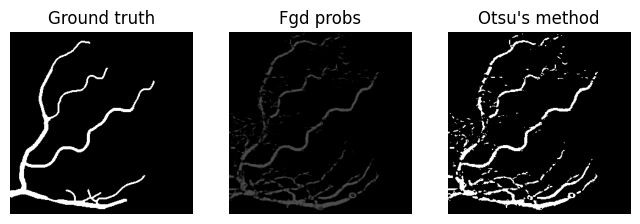

otsu threshold = 0.1262


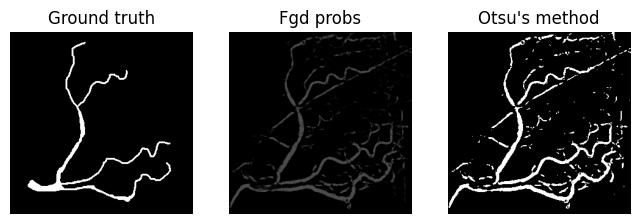

otsu threshold = 0.1227


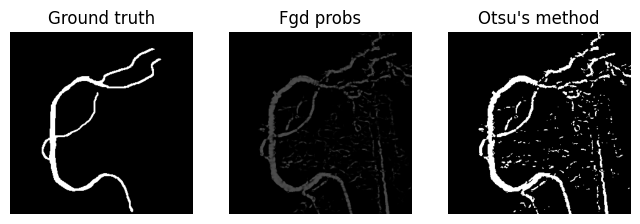

otsu threshold = 0.1239


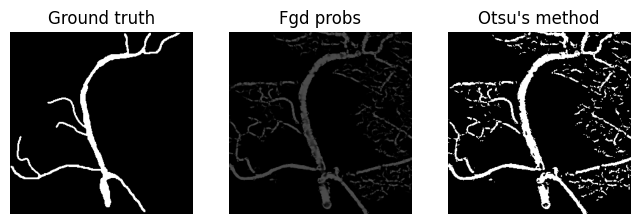

otsu threshold = 0.1251


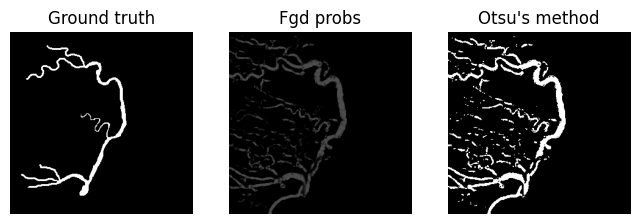

otsu threshold = 0.1297


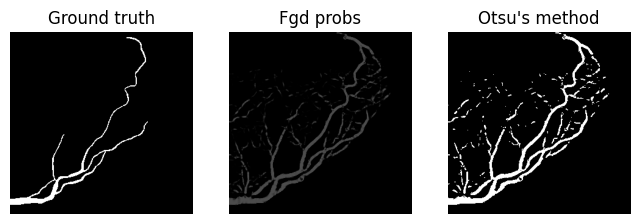

otsu threshold = 0.1251


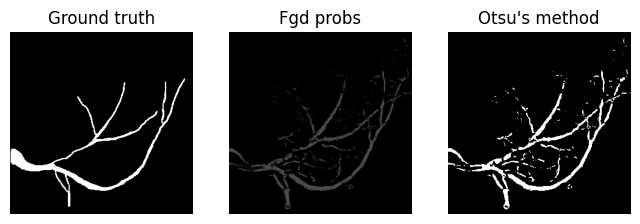

otsu threshold = 0.1309


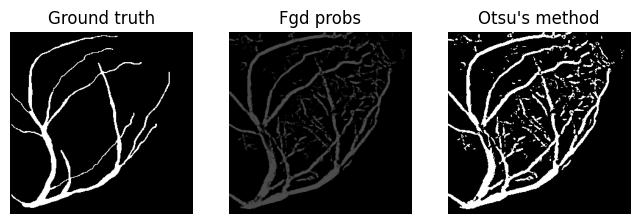

otsu threshold = 0.1251


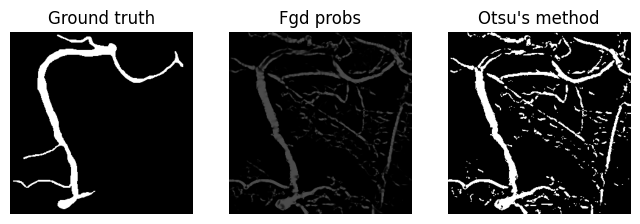

otsu threshold = 0.1274


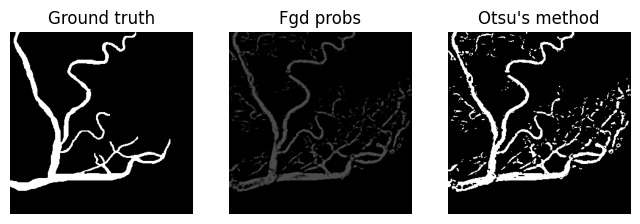

otsu threshold = 0.1251


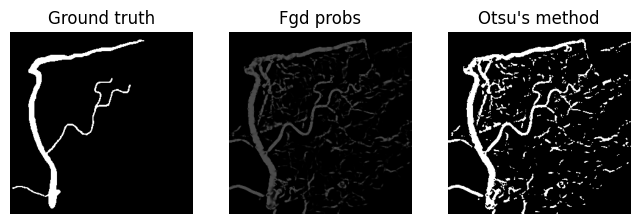

otsu threshold = 0.1227


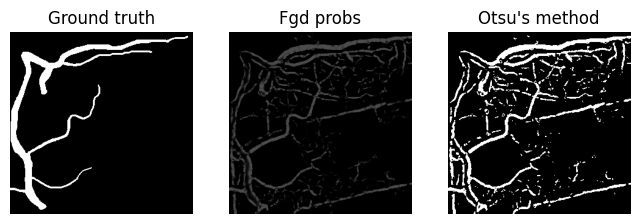

otsu threshold = 0.1274


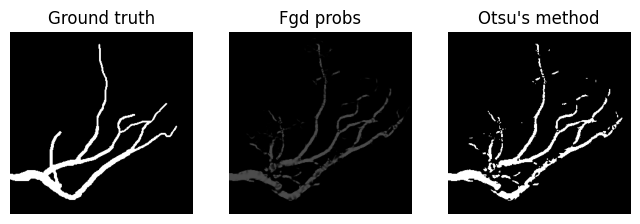

otsu threshold = 0.1239


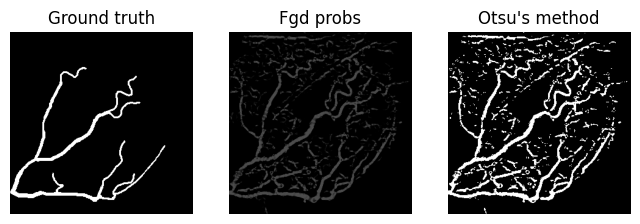

otsu threshold = 0.1239


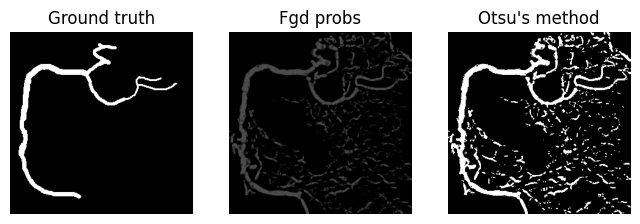

otsu threshold = 0.1251


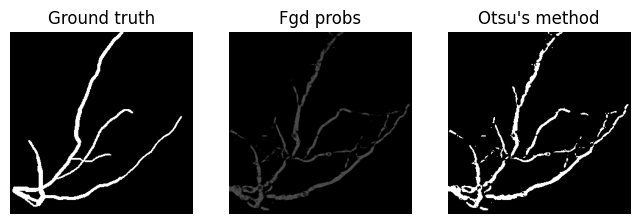

In [31]:
def otsu(fgdprobs):
  # iterate over 1st dimension of the 3D array fgdprobs
  # fg are (1, 300, 300) slices along 1st dim of fgdprobs
  threshs = np.array([threshold_otsu(fg) for fg in fgdprobs])
  bin_masks = fgdprobs > threshs[:, np.newaxis, np.newaxis]   # broadcasting threshs to be compatible with fgdprobs
  return bin_masks.astype(np.float32)

nfilters = 1
def segment(model, val_loader):
  model.eval()
  device = next(model.parameters()).device

  for x, y in val_loader:
    x = x.to(device)
    x_flat = x.view(x.size(0), -1, nfilters).view(-1, nfilters)

    with torch.no_grad():
      preds = model(x_flat)
    preds = torch.softmax(preds, dim=1).view(x.size(0), 300, 300, 2)   # x.size(0) == batch_size
    fgdprobs = preds[..., 1].cpu().numpy()   # fgdprobs has size (batch_size, 300, 300)
                     # selects class label 1
    bin_masks = otsu(fgdprobs)

    for i in range(x.size(0)):
      print(f'otsu threshold = {threshold_otsu(fgdprobs[i]):.4f}')
      plt.figure(figsize=(8, 4))
      plt.subplot(1, 3, 1)
      plt.imshow(y[i, :, :, 1].cpu(), cmap='gray')
      plt.title('Ground truth')
      plt.axis('off')
      plt.subplot(1, 3, 2)
      plt.imshow(fgdprobs[i], cmap='gray', vmin=0, vmax=1)
      plt.title('Fgd probs')
      plt.axis('off')
      plt.subplot(1, 3, 3)
      plt.imshow(bin_masks[i], cmap='gray', vmin=0, vmax=1)
      plt.title('Otsu\'s method')
      plt.axis('off')
      plt.show()

segment(model, val_loader)


# SNRs

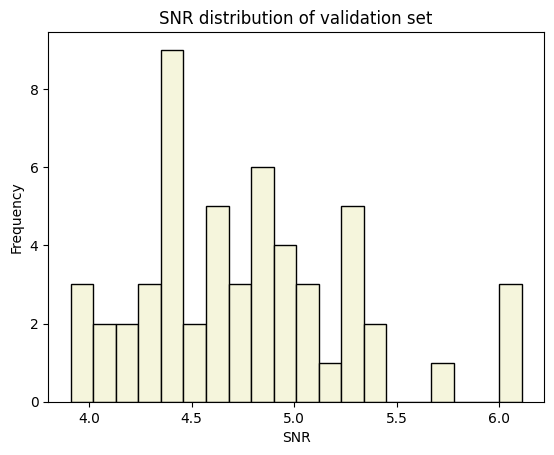

Avg SNR = 4.772


In [32]:
def snr(model, val_loader):
  model.eval()
  device = next(model.parameters()).device
  snrs = []

  for x, _ in val_loader:
    # x is a batch
    x = x.to(device)
    x_flat = x.view(x.size(0), -1, nfilters).view(-1, nfilters)
    with torch.no_grad():
      probs = torch.softmax(model(x_flat), dim=1).view(x.size(0), 300, 300, 2)

    fgdprobs = probs[..., 1].cpu().numpy()
    # fgdprobs has shape (batch_size, 300, 300)
    threshs = np.array([threshold_otsu(fg) for fg in fgdprobs])
    # Otsu's threshold applies to foreground probabilities:
    binary_masks = fgdprobs > threshs[:, np.newaxis, np.newaxis]   # broadcasting threshs to be compatible with fgdprobs
    # binary_masks is 3D array of bools

    for i in range(fgdprobs.shape[0]):   # for image in batch
      fgd_pixels = fgdprobs[i][binary_masks[i] == 1]
      # fgdprobs[i] has shape (300, 300)
      # binary_masks[i] is (300, 300) array of bools

      # snr of the image
      snr = np.mean(fgd_pixels) / np.std(fgd_pixels)
      snrs.append(snr)
  avg_snr = np.mean(snrs)
  plt.hist(snrs, bins=20, color='beige', edgecolor='black')
  plt.title('SNR distribution of validation set')
  plt.xlabel('SNR')
  plt.ylabel('Frequency')
  plt.show()

  print(f'Avg SNR = {avg_snr:.3f}')

snr(model, val_loader)


#AUROCs

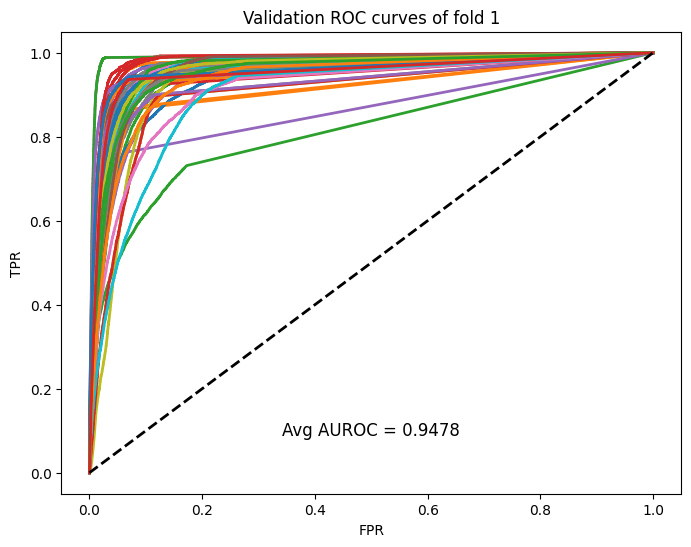

[0.9536215802654547,
 0.9154448199793301,
 0.9455547044680966,
 0.9826871984039015,
 0.9413888995265987,
 0.9686847748061285,
 0.9890991260939608,
 0.9445803356088969,
 0.9041124180747788,
 0.964577086296121,
 0.9641435506854753,
 0.9694701314320257,
 0.9677169949087152,
 0.9772336816335728,
 0.9714247212738741,
 0.960649310081326,
 0.9656177364686902,
 0.9259674595686062,
 0.9578156827030129,
 0.950631162511249,
 0.9334942500893936,
 0.9179041396583585,
 0.812767986766212,
 0.9378384877075413,
 0.8607950817340864,
 0.9582778464720205,
 0.9535996810941316,
 0.949194556968805,
 0.9389647776249491,
 0.9536215802654547,
 0.9686847748061285,
 0.9507776527599461,
 0.9890991260939608,
 0.9041124180747788,
 0.9586287781158778,
 0.9598430279886192,
 0.964577086296121,
 0.9656813922963999,
 0.9500021430117702,
 0.96283861417793,
 0.9633027321084726,
 0.9516306737619546,
 0.960626469206356,
 0.9831494253400159,
 0.9259674595686062,
 0.9578156827030129,
 0.912442834321627,
 0.950631162511249,
 0.

In [34]:
def rocs(ys, ypred, aurocs, foldn):
  """Plots validation ROC curves of one fold."""
  plt.figure(figsize=(8, 6))
  for i in range(len(ys)):
    fpr, tpr, _ = roc_curve(ys[i], ypred[i])   # for binary classifiers
    roc_auc = auc(fpr, tpr)
    aurocs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2)
  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  avg_auroc = np.nanmean(aurocs)        # avoids div 0
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title(f'Validation ROC curves of fold {foldn}')
  plt.text(0.5, 0.1, f'Avg AUROC = {avg_auroc:.4f}', fontsize=12, ha='center',
           va='center')
  plt.show()

def aurocs(model, foldn, valoader):
  model.eval()
  aurocs = []
  ys = []
  ypred = []

  with torch.no_grad():
   for x, y in valoader:
     x = x.to(next(model.parameters()).device)
     x_flat = x.view(x.size(0), 300 * 300, nfilters).view(-1, nfilters)
     preds = model(x_flat)
     preds = preds.view(x.size(0), 300, 300, 2)
     fgdprobs = preds[..., 1].cpu().numpy()
     gt = y.numpy()

     for i in range(x.size(0)):
      y_true = gt[i, :, :, 1].flatten()
      y_scores = fgdprobs[i].flatten()
      if np.unique(y_true).size > 1:
        aurocs.append(roc_auc_score(y_true, y_scores))
      else:
        aurocs.append(np.nan)

      ys.append(y_true)
      ypred.append(y_scores)

  rocs(ys, ypred, aurocs, foldn)

  return aurocs

aurocs(model, 1, val_loader)


#Performance Metrics

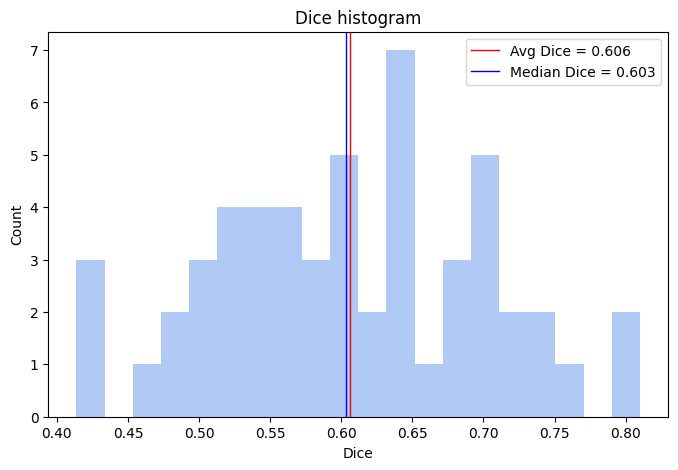

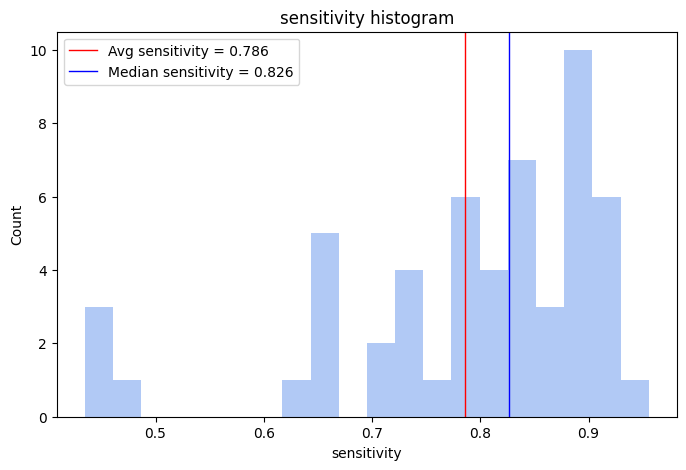

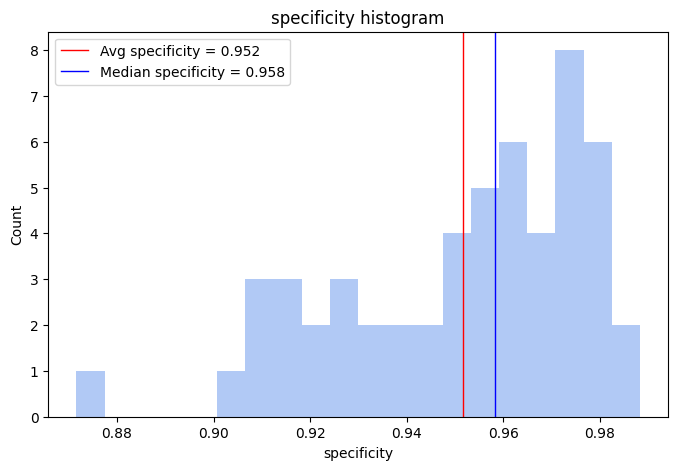

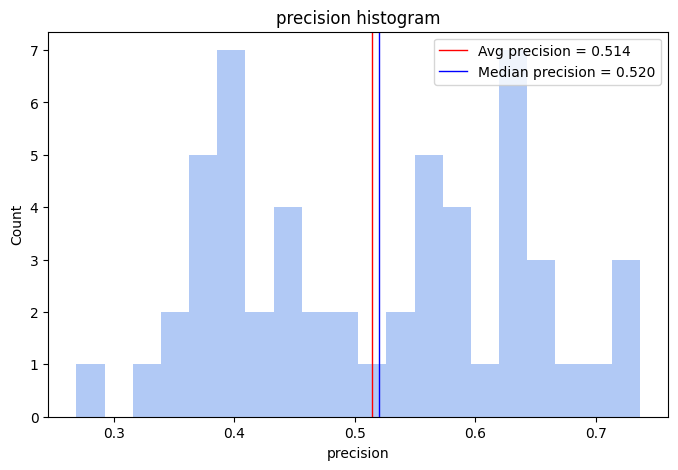

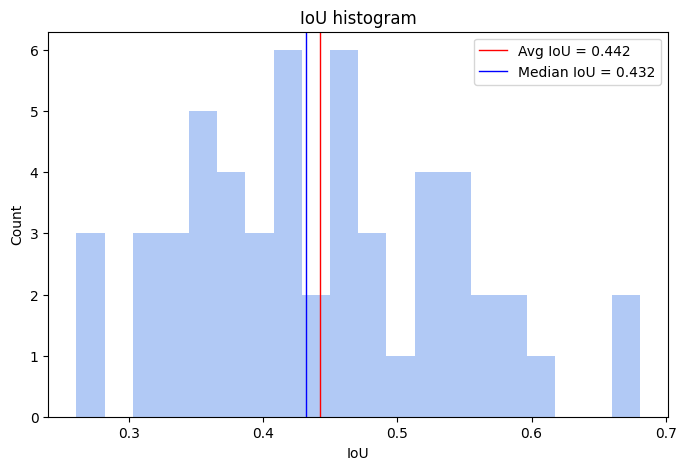

In [37]:
def otsu2(fgdprobs):
  thresholds = np.array([threshold_otsu(fgdprobs[i]) for i in range(fgdprobs.shape[0])])
  binary_masks = fgdprobs > thresholds[:, np.newaxis, np.newaxis]
  return binary_masks.astype(np.float32)


def pmetrics(gt, y_pred):
  tp = np.sum((gt==1) & (y_pred==1))
  fp = np.sum((gt==0) & (y_pred==1))
  tn = np.sum((gt==0) & (y_pred==0))
  fn = np.sum((gt == 1) & (y_pred == 0))
  dice = 2 * tp / (2 * tp + fp + fn) if (tp + fp + fn) > 0 else 1   # else: no foreground pixels
  sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
  specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
  precision = tp / (tp + fp) if (tp + fp) > 0 else 0
  union = tp + fp + fn
  iou = tp / union if union > 0 else 1
  return dice, sensitivity, specificity, precision, iou


def histo_metrics(model, val_loader):
  model.eval()
  metrics = {"Dice": [], "sensitivity": [], "specificity": [], "precision": [], "IoU": []}

  with torch.no_grad():
    for x, y in val_loader:
      x = x.to(next(model.parameters()).device)
      x_flat = x.view(x.size(0), 300 * 300, nfilters).view(-1, nfilters)
      preds = model(x_flat)
      preds = torch.softmax(preds, dim=1)
      preds = preds.view(x.size(0), 300, 300, 2)
      fgdprobs = preds[..., 1].cpu().numpy()
      binary_masks = otsu2(fgdprobs)
      gt = y.numpy()

      for i in range(x.size(0)):
        y_true = gt[i, :, :, 1].flatten()
        y_pred = binary_masks[i].flatten()
        dice, sensitivity, specificity, precision, iou = pmetrics(y_true, y_pred)
        metrics["Dice"].append(dice)
        metrics["sensitivity"].append(sensitivity)
        metrics["specificity"].append(specificity)
        metrics["precision"].append(precision)
        metrics["IoU"].append(iou)

  # histograms
  for key, val in metrics.items():
    plt.figure(figsize=(8, 5))
    plt.hist(val, bins=20, color='cornflowerblue', alpha=0.5)
    plt.axvline(np.mean(val), color='r', linewidth=1, label=f'Avg {key} = {np.mean(val):.3f}')
    plt.axvline(np.median(val), color='blue', linewidth=1, label=f'Median {key} = {np.median(val):.3f}')
    plt.title(f'{key} histogram')
    plt.xlabel(key)
    plt.ylabel('Count')
    plt.legend()
    plt.show()

  return metrics


metrics = histo_metrics(model, val_loader)
